Nesse notebook é possível carregar um modelo pré-treinado, fazer a inferência no mapa da represa de três marias e gerar uma imagem de quais pontos da represa o modelo pré-treinado considerou como anomalia ou como condição normal, dada a variável de turbidez.

In [ ]:
# instalar bibliotecas necessárias para colab
!pip install --upgrade --no-cache-dir gdown
!pip install geopandas
!pip install pandas==1.4.2
#!pip install scikit-learn==1.1.0
!rm -r sample_data/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
# carregar bibliotecas
import pickle
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# fazer download do modelo pré-treinado
!gdown '17goFrMn5C6KhI0wK3YgCtU8EZTTiA5xo'

# carregar o modelo salvo em disco
model = pickle.load(open('modelo_deteccao_anomalias', 'rb'))

Downloading...
From: https://drive.google.com/uc?id=17goFrMn5C6KhI0wK3YgCtU8EZTTiA5xo
To: /content/modelo_deteccao_anomalias
100% 1.14M/1.14M [00:00<00:00, 68.6MB/s]


In [ ]:
# fazer download do dataset que representa a represa de Três Marias
!gdown '18FbDtMWmv4LrhN504C3RRAL58x62Lufc'

# fazer download do arquivo scaler para pre processamento dos dados
!gdown '1t-2_H4k017nGxouuwpZpdksZLIeWsnvM'

Downloading...
From: https://drive.google.com/uc?id=18FbDtMWmv4LrhN504C3RRAL58x62Lufc
To: /content/mapa_pixels_tres_marias.pkl
100% 422M/422M [00:02<00:00, 198MB/s]
Downloading...
From: https://drive.google.com/uc?id=1t-2_H4k017nGxouuwpZpdksZLIeWsnvM
To: /content/scaler.sav
100% 737/737 [00:00<00:00, 1.10MB/s]


In [ ]:
# fazer inferencia com o mapa gerado em cada um das amostras
# carregar dataset que representa o mapa de Três Marias
mapa_df = pd.read_pickle("mapa_pixels_tres_marias.pkl")

In [ ]:
# carregar arquivo scaler e realizar pre processamento
scalerfile = 'scaler.sav'
scaler = pickle.load(open(scalerfile, 'rb'))

mapa_bandas=mapa_df[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12']]
mapa_bandas2 = mapa_bandas*10000
norm_X_mapa = scaler.transform(mapa_bandas2)
print("Tamanho mapa:", norm_X_mapa.shape)

Tamanho mapa: (2132649, 12)


In [ ]:
# realizar a predição em todo o mapa da represa
grid_predictions_mapa = model.predict(norm_X_mapa)
# Inlier Prediction: +1
# Outlier Prediction: -1
grid_predictions_mapa[grid_predictions_mapa == 1] = 0
grid_predictions_mapa[grid_predictions_mapa == -1] = 1

In [ ]:
# verificar quantidade por classe
print(np.array(np.unique(grid_predictions_mapa, return_counts=True)).T)
#grid_if_predictions_mapa

[[      0 1632975]
 [      1  499674]]


In [ ]:
# visualizar tabela gerada para mapa
df_coord_class = mapa_df
df_coord_class['classe'] = grid_predictions_mapa.tolist()
df_coord_class = df_coord_class[['geometry','classe']]

df_coord_class

,geometry,classe
0,"POLYGON ((466540.000 7988920.000, 466540.000 7...",1
1,"POLYGON ((466560.000 7988920.000, 466560.000 7...",1
2,"POLYGON ((466580.000 7988920.000, 466580.000 7...",1
3,"POLYGON ((466540.000 7988900.000, 466540.000 7...",1
4,"POLYGON ((466560.000 7988900.000, 466560.000 7...",1
...,...,...
2132644,"POLYGON ((488420.000 7892380.000, 488420.000 7...",1
2132645,"POLYGON ((488440.000 7892380.000, 488440.000 7...",1
2132646,"POLYGON ((488460.000 7892380.000, 488460.000 7...",1
2132647,"POLYGON ((488180.000 7892360.000, 488180.000 7...",1


Text(0.5, 1.0, 'Turbidez - Detecção de Anomalias: Reservatório de Três Marias, 21/01/2021')

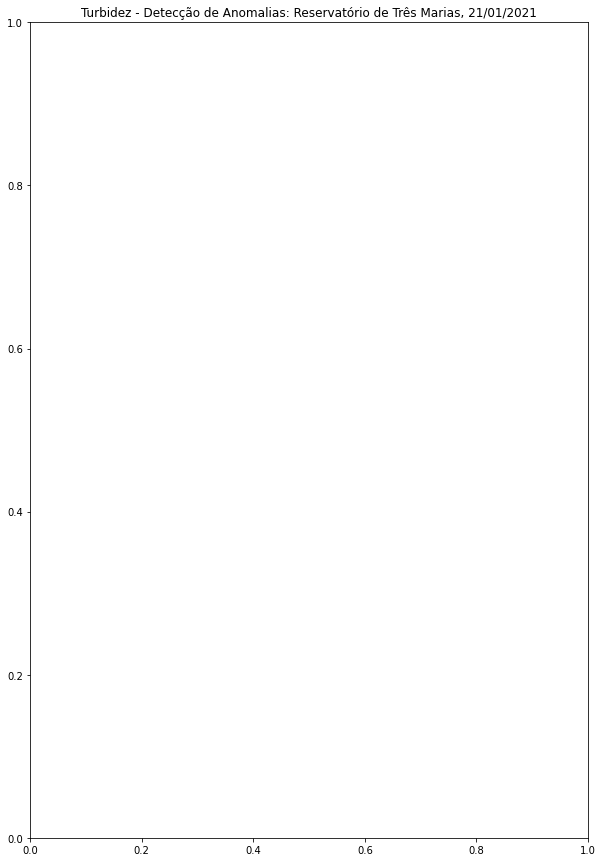

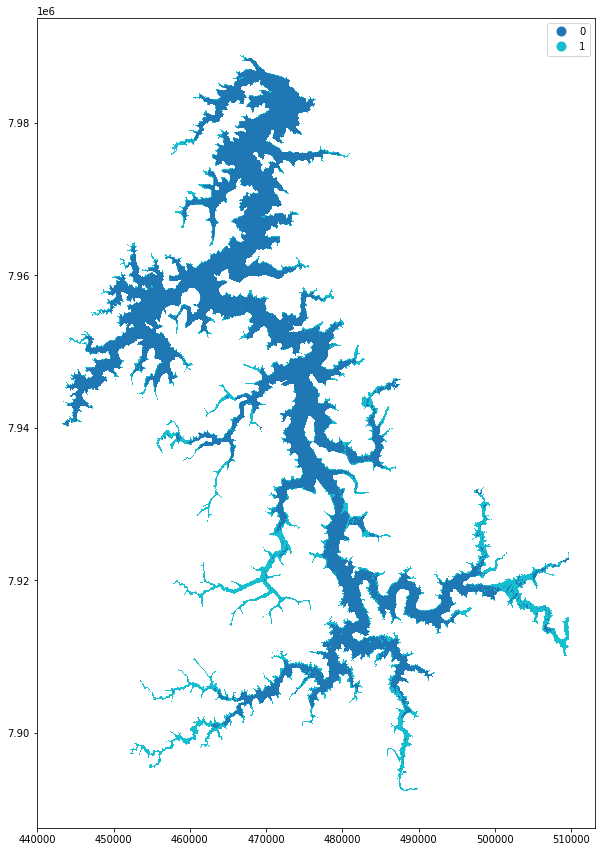

In [ ]:
# visualizar mapa
geodataframe_class = gpd.GeoDataFrame(df_coord_class, geometry='geometry')
rcParams['figure.figsize'] = 10,15

fig, ax = plt.subplots(1, 1)
geodataframe_class.plot(column='classe', legend = True, categorical= True)
ax.set_title( 'Turbidez - Detecção de Anomalias: Reservatório de Três Marias, 21/01/2021')

In [ ]:
# salvar em disco mapa gerado
geodataframe_class.to_file('Mapa_TresMarias.shp', driver='ESRI Shapefile')